# Máy học nâng cao - Lab 05
# Họ tên: Nguyễn Phú Thành - MSSV: 18110014

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, GRU, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-04/spam_detection.csv")
df.head()

,Text,Label,y
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [3]:
df.shape

(5574, 3)

In [4]:
nltk.download('punkt')
texts = df["Text"].to_list()
texts = [text.lower() for text in texts]
tokenized_texts = [nltk.tokenize.word_tokenize(text) for text in texts]
print(tokenized_texts[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['go', 'until', 'jurong', 'point', ',', 'crazy..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amore', 'wat', '...']


In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-11-13 09:57:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-13 09:57:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-13 09:57:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [6]:
def load_word_embeddings(fname):
    vocab, matrix = [], []
    with open(fname, mode = 'r', encoding = 'utf-8', errors = 'ignore', newline = '\n') as fin:
        for line in fin:
            tokens = line.rstrip().split(' ')
            vocab.append(tokens[0])
            matrix.append(list(map(float, tokens[1:])))
    return vocab, np.asarray(matrix)

In [7]:
vocab, matrix = load_word_embeddings("glove.6B.100d.txt")
word_to_index = {word: index + 2 for index, word in enumerate(vocab)}

In [8]:
## Gán các mã
__PADDED_INDEX__ = 0    # mã dùng cho các vị trí chỉ có tính nối dài cho cùng kích thước
__UNKNOWN_WORD__ = 1    # mã cho những từ không có trong embedding

In [9]:
embedding_matrix = np.pad(matrix, ((2,0),(0,0)), mode = 'constant', constant_values = 0.0)
print(embedding_matrix)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [-0.038194 -0.24487   0.72812  ... -0.1459    0.8278    0.27062 ]
 ...
 [ 0.36088  -0.16919  -0.32704  ...  0.27139  -0.29188   0.16109 ]
 [-0.10461  -0.5047   -0.49331  ...  0.42527  -0.5125   -0.17054 ]
 [ 0.28365  -0.6263   -0.44351  ...  0.43678  -0.82607  -0.15701 ]]


In [10]:
X = []
for text in tokenized_texts:
    cur_text_indices = []
    for word in text:
        cur_text_indices.append(word_to_index[word]) if word in word_to_index else cur_text_indices.append(__UNKNOWN_WORD__)
    X.append(cur_text_indices)

# pad data cho có cùng chiều dài
X = tf.keras.preprocessing.sequence.pad_sequences(sequences = X,       # sequences: list các câu có độ dài không bằng nhau
                                                  padding='post')    # vị trí pad là 'pre' (trước) hoặc 'post' (sau)

y = df['y'].values   ## Label của bài toán, 0 là không phải spam, 1 là spam

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [12]:
inputs = Input(shape = (None,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(
    input_dim = embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
    output_dim = embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
    embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
    trainable = False,                       ## Không cần thiết train embedding
    mask_zero = True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

lstm = LSTM(
    units = 100,                          ## units: kích thước của hidden_state trong LSTM
    return_sequences = False)(embed)      ## return_sequences: LSTM trả về toàn bộ  hay là trả về hidden_state cuối cùng

dense = Dense(
    units = 2, 
    activation = 'softmax')(lstm)
model = Model(
    inputs = inputs,
    outputs = dense)

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         40000200  
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 40,080,802
Trainable params: 80,602
Non-trainable params: 40,000,200
_________________________________________________________________


In [13]:
history_lstm_1 = model.fit(
    X_train, y_train, 
    batch_size = 100, epochs = 10, 
    validation_data = (X_valid, y_valid)
)

Epoch 1/10
45/45 [==============================] - 13s 69ms/step - loss: 0.2331 - accuracy: 0.9121 - val_loss: 0.1224 - val_accuracy: 0.9632
Epoch 2/10
45/45 [==============================] - 1s 32ms/step - loss: 0.0875 - accuracy: 0.9706 - val_loss: 0.1174 - val_accuracy: 0.9587
Epoch 3/10
45/45 [==============================] - 1s 32ms/step - loss: 0.0716 - accuracy: 0.9758 - val_loss: 0.0828 - val_accuracy: 0.9767
Epoch 4/10
45/45 [==============================] - 1s 32ms/step - loss: 0.0554 - accuracy: 0.9839 - val_loss: 0.0720 - val_accuracy: 0.9785
Epoch 5/10
45/45 [==============================] - 1s 32ms/step - loss: 0.0905 - accuracy: 0.9735 - val_loss: 0.0807 - val_accuracy: 0.9767
Epoch 6/10
45/45 [==============================] - 1s 32ms/step - loss: 0.0578 - accuracy: 0.9818 - val_loss: 0.0679 - val_accuracy: 0.9776
Epoch 7/10
45/45 [==============================] - 1s 32ms/step - loss: 0.0442 - accuracy: 0.9865 - val_loss: 0.0674 - val_accuracy: 0.9821
Epoch 8/10
4

In [14]:
inputs = Input(shape = (None,))                   ## None biểu thị kích thước không xác định của câu

embed = Embedding(
    input_dim = embedding_matrix.shape[0],   ## Khai báo kích thước của vocab
    output_dim = embedding_matrix.shape[1],   ## Khai báo kích thước của embedding
    embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),  ## Khởi tạo cho embedding bằng ma trận có sẵn
    trainable = False,                       ## Không cần thiết train embedding
    mask_zero = True)(inputs)                 ## zero_mask: những vị trí có giá trị 0 không được tính toán, vì đó là giá trị thêm vào cho đủ độ dài mà thôi
                                                         ##  (__PADDED_INDEX__ gán bằng 0)

lstm = LSTM(
    units = 100,                          ## units: kích thước của hidden_state trong LSTM
    return_sequences = True,
    return_state = True)(embed)      ## return_sequences: LSTM trả về toàn bộ  hay là trả về hidden_state cuối cùng
global_maxpool = GlobalAveragePooling1D()(lstm[0])
dense = Dense(units=2, activation='softmax')(global_maxpool)
model = Model(
    inputs = inputs,
    outputs = dense)

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         40000200  
                                                                 
 lstm_1 (LSTM)               [(None, None, 100),       80400     
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                           

In [15]:
history_lstm_2 = model.fit(
    X_train, y_train, 
    batch_size = 100, epochs = 10, 
    validation_data = (X_valid, y_valid)
)

Epoch 1/10
45/45 [==============================] - 8s 68ms/step - loss: 0.2672 - accuracy: 0.9038 - val_loss: 0.1289 - val_accuracy: 0.9650
Epoch 2/10
45/45 [==============================] - 1s 33ms/step - loss: 0.1004 - accuracy: 0.9666 - val_loss: 0.0981 - val_accuracy: 0.9641
Epoch 3/10
45/45 [==============================] - 1s 33ms/step - loss: 0.0836 - accuracy: 0.9717 - val_loss: 0.0851 - val_accuracy: 0.9758
Epoch 4/10
45/45 [==============================] - 1s 32ms/step - loss: 0.0673 - accuracy: 0.9814 - val_loss: 0.0797 - val_accuracy: 0.9695
Epoch 5/10
45/45 [==============================] - 1s 32ms/step - loss: 0.0605 - accuracy: 0.9803 - val_loss: 0.0899 - val_accuracy: 0.9731
Epoch 6/10
45/45 [==============================] - 2s 34ms/step - loss: 0.0504 - accuracy: 0.9852 - val_loss: 0.0724 - val_accuracy: 0.9731
Epoch 7/10
45/45 [==============================] - 1s 33ms/step - loss: 0.0565 - accuracy: 0.9809 - val_loss: 0.0728 - val_accuracy: 0.9722
Epoch 8/10
45

# Bài tập

# 1. Tìm hiểu về cách dùng của GRU và chạy theo 2 cách hướng dẫn ở trên



In [16]:
inputs = Input(shape = (None,))

embed = Embedding(
    input_dim = embedding_matrix.shape[0],
    output_dim = embedding_matrix.shape[1],
    embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),
    trainable = False,
    mask_zero = True)(inputs)
gru = GRU(
    units = 100, 
    return_sequences = False)(embed)
dense = Dense(
    units = 2, 
    activation = 'softmax')(gru)
model = Model(
    inputs = inputs,
    outputs = dense)

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         40000200  
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 40,061,002
Trainable params: 60,802
Non-trainable params: 40,000,200
_________________________________________________________________


In [17]:
history_gru_1 = model.fit(
    X_train, y_train,
    batch_size = 100, epochs = 10, 
    validation_data = (X_valid, y_valid)
)

Epoch 1/10
45/45 [==============================] - 8s 63ms/step - loss: 0.2420 - accuracy: 0.9074 - val_loss: 0.1138 - val_accuracy: 0.9596
Epoch 2/10
45/45 [==============================] - 1s 28ms/step - loss: 0.0868 - accuracy: 0.9702 - val_loss: 0.0840 - val_accuracy: 0.9704
Epoch 3/10
45/45 [==============================] - 1s 28ms/step - loss: 0.0629 - accuracy: 0.9794 - val_loss: 0.0758 - val_accuracy: 0.9758
Epoch 4/10
45/45 [==============================] - 1s 29ms/step - loss: 0.0545 - accuracy: 0.9830 - val_loss: 0.0689 - val_accuracy: 0.9731
Epoch 5/10
45/45 [==============================] - 1s 28ms/step - loss: 0.0445 - accuracy: 0.9881 - val_loss: 0.0645 - val_accuracy: 0.9785
Epoch 6/10
45/45 [==============================] - 1s 28ms/step - loss: 0.0394 - accuracy: 0.9879 - val_loss: 0.0598 - val_accuracy: 0.9803
Epoch 7/10
45/45 [==============================] - 1s 28ms/step - loss: 0.0299 - accuracy: 0.9904 - val_loss: 0.0554 - val_accuracy: 0.9839
Epoch 8/10
45

In [18]:
inputs = Input(shape = (None,))

embed = Embedding(
    input_dim = embedding_matrix.shape[0],
    output_dim = embedding_matrix.shape[1],
    embeddings_initializer = tf.keras.initializers.Constant(value=embedding_matrix),
    trainable = False,
    mask_zero = True)(inputs)
gru = GRU(
    units = 100, 
    return_sequences = True, 
    return_state = True)(embed)
global_maxpool = GlobalAveragePooling1D()(gru[0])
dense = Dense(units = 2, activation = 'softmax')(global_maxpool)
model = Model(inputs = inputs,
              outputs = dense)

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         40000200  
                                                                 
 gru_1 (GRU)                 [(None, None, 100),       60600     
                              (None, 100)]                       
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 40,061,002
Trainable params: 60,802
Non-train

In [19]:
history_gru_2 = model.fit(
    X_train, y_train, 
    batch_size = 100, epochs = 10, 
    validation_data = (X_valid, y_valid)
)

Epoch 1/10
45/45 [==============================] - 8s 72ms/step - loss: 0.3371 - accuracy: 0.8475 - val_loss: 0.2402 - val_accuracy: 0.8978
Epoch 2/10
45/45 [==============================] - 1s 29ms/step - loss: 0.1365 - accuracy: 0.9540 - val_loss: 0.1024 - val_accuracy: 0.9686
Epoch 3/10
45/45 [==============================] - 1s 30ms/step - loss: 0.0817 - accuracy: 0.9735 - val_loss: 0.0864 - val_accuracy: 0.9731
Epoch 4/10
45/45 [==============================] - 1s 30ms/step - loss: 0.0657 - accuracy: 0.9782 - val_loss: 0.0803 - val_accuracy: 0.9740
Epoch 5/10
45/45 [==============================] - 1s 29ms/step - loss: 0.0545 - accuracy: 0.9825 - val_loss: 0.0704 - val_accuracy: 0.9740
Epoch 6/10
45/45 [==============================] - 1s 29ms/step - loss: 0.0549 - accuracy: 0.9823 - val_loss: 0.0654 - val_accuracy: 0.9767
Epoch 7/10
45/45 [==============================] - 1s 30ms/step - loss: 0.0561 - accuracy: 0.9807 - val_loss: 0.0649 - val_accuracy: 0.9776
Epoch 8/10
45

# 2. So sánh giữa 2 cấu trúc của GRU và LSTM. Từ đó đưa ra kết luận của mình (có dẫn chứng )

1. Với cùng số unit là 100, khi cho return_sequences = False thì cả hai lớp GRU và LSTM cho cùng một output shape (None, 100). Tuy nhiên, lớp LSTM có nhiều số param hơn lớp GRU (lớp LSTM trong trường hợp này có 80400 param trong khi lớp GRU chỉ có 60600 param)

2. Với cùng số unit là 100, khi cho return_sequences = True thì lớp LSTM cho 3 output với kích thước là (None, None, 100), (None, 100) và (None, 100).
Trong khi đó, lớp GRU chỉ cho 2 output với kích thước lần lượt là (None, None, 100) và (None, 100)

3. Về thời gian chạy giữa LSTM và GRU, với cùng số lượng epoch và batch size trên cùng một tập train trong bài thì mô hình LSTM trung bình mất khoảng 2s/1 epoch còn mô hình GRU trung bình mất khoảng 1.6s/1 epoch, tức mô hình GRU chạy ***nhanh hơn một chút*** so với mô hình LSTM

**Kết luận:** Mô hình GRU gọn nhẹ hơn, chạy nhanh hơn (***không đáng kể***) so với mô hình LSTM, tuy nhiên ta khó so sánh về độ chính xác ở hai mô hình LSTM và GRU, đôi khi mô hình LSTM tốt hơn, đôi khi mô hình GRU lại tốt hơn (***xem các biểu đồ ở phía dưới***)

In [20]:
def plot_history(history, n_epochs = 10):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
    axes[0].plot(np.arange(1, n_epochs + 1), history.history['loss'], color = 'b', marker = 'o', label = 'Training Loss')
    axes[0].plot(np.arange(1, n_epochs + 1), history.history['val_loss'], color = 'r', marker = 'o', label = 'Validation Loss')

    axes[1].plot(np.arange(1, n_epochs + 1), history.history['accuracy'], color = 'b', marker = 'o', label = 'Training Accuracy')
    axes[1].plot(np.arange(1, n_epochs + 1), history.history['val_accuracy'], color = 'r', marker = 'o', label = 'Validation Accuracy')
    
    for ax in axes.flatten():
        ax.set(xticks = np.arange(1, n_epochs + 1))
        ax.grid(True)
        ax.legend()
    plt.show()

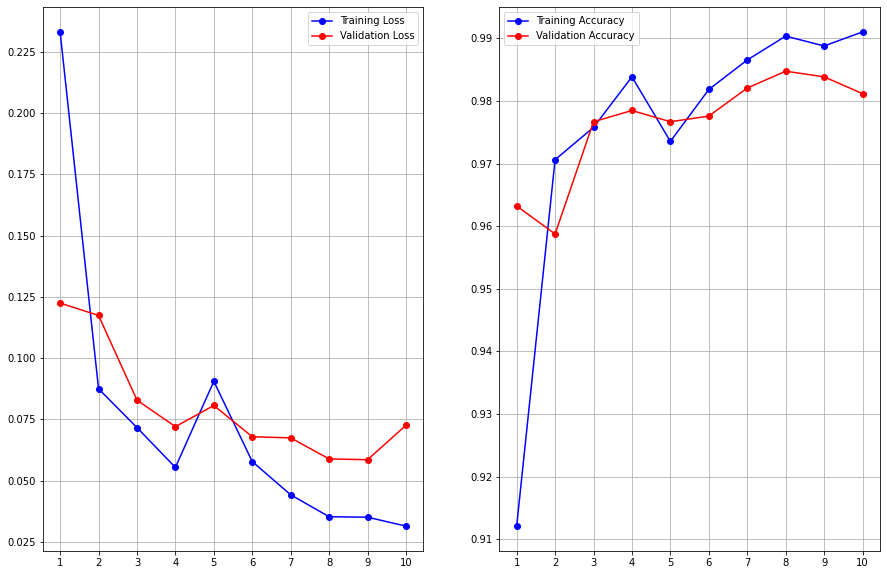

In [21]:
plot_history(history_lstm_1)

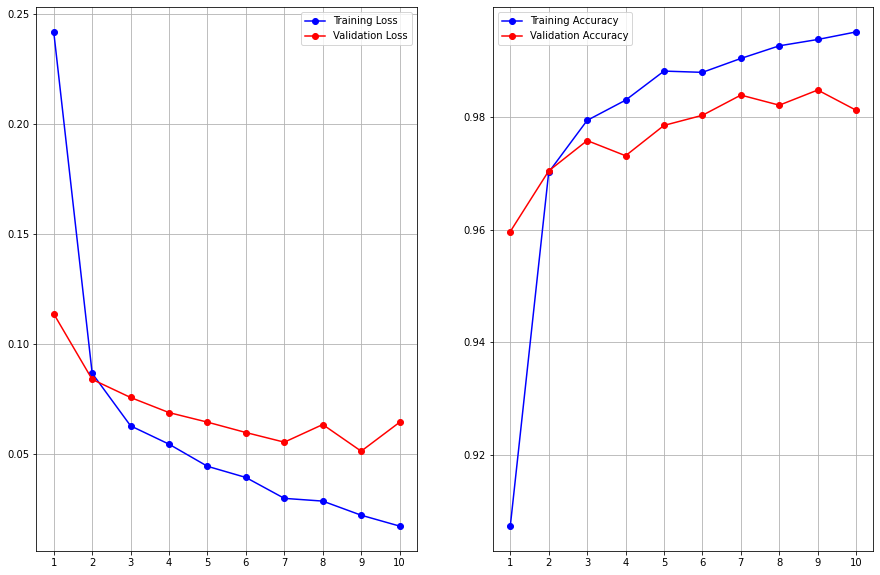

In [22]:
plot_history(history_gru_1)

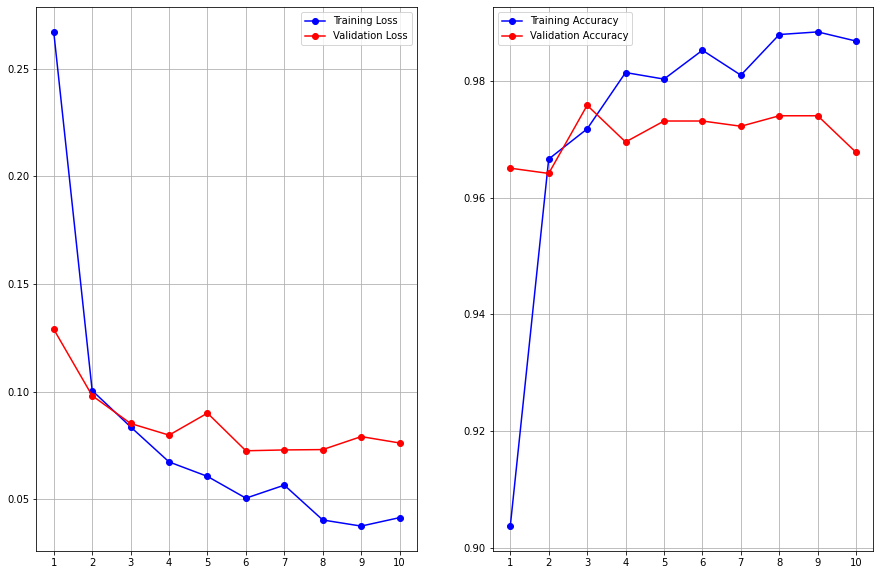

In [23]:
plot_history(history_lstm_2)

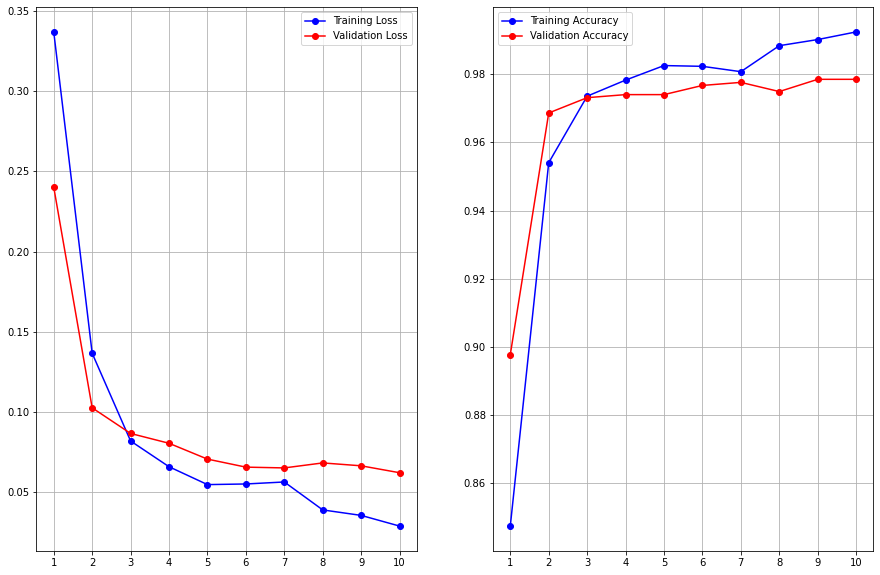

In [24]:
plot_history(history_gru_2)